In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap
from functools import reduce

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters

2025-02-25 10:11:04.450931: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 10:11:04.588472: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 10:11:05.695284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 10:11:05.700093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 10:11:07.716759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID

# GTM data
"""
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks
"""
size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)
"""

'\nsize_chunck = 20_000\nmin_maf = 0.01\n\npath_raw = f"{CONFIG[\'PATH_data\']}/01_raw/geno.pkl"\npath_afs = f"{CONFIG[\'PATH_data\']}/02_usefull/allele_frequencies.pkl"\npath_output = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\n\ndivide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)\n'

# Choose SNPs to project on n dimensions

# Observe raw dimensions

In [3]:
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/00_raw/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
ids = ids.merge(labels, left_on="IID", right_on="Sample name")

In [4]:
"""
path_macro_similar = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
iterations = 3

for iter in list(range(iterations)):
    print(f"Running iteration {iter}")
    path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    
    if iter == 0:
        ids[f"cluster_{iter}"] = f"{0}"
        os.makedirs(f"{path_output}/pop_{0}", exist_ok=True)
        ids.to_pickle(f"{path_output}/pop_{0}/ids.pkl")
        
    else:
        pass
    
    cluster_to_add = []
    for sub_pop in ids[f"cluster_{iter}"].unique():
        path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/pop_{sub_pop}/"
        os.makedirs(path_output, exist_ok=True)
        temp_ids = ids[ids[f"cluster_{iter}"] == sub_pop]
        nr_of_projected_dimensions = 3
        geno = project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10)
        
        existing_dims = []   
        for PCs in [f for f in os.listdir(path_output) if f.startswith('PCs')]:
            dim = PCs.split('PCs_')[1].split('.pkl')[0]
            path_PC = f"{path_output}/{PCs}"
            PCs = pd.read_pickle(f"{path_PC}")
            temp_ids = temp_ids.copy()
            temp_ids[dim] = list(PCs['PC1'])
            existing_dims.append(dim)
        labels = silhouette_score_clusters(temp_ids, existing_dims, plot=False)
        for element in labels:
            cluster_to_add.append(f"{sub_pop}_{element}")
            
    ids[f"cluster_{iter+1}"] = cluster_to_add
    ids.to_pickle(f"{CONFIG['PATH_data']}/iteration_{iter}/ids.pkl")
    
    # Vizualization
    path_input = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        temp_ids = ids[ids[f"cluster_{iter}"] == pop]
        path_pop = f"{path_input}/pop_{pop}"
        for PCs in [f for f in os.listdir(path_pop) if f.startswith('PCs')]:
            dim = PCs.split('PCs_')[1].split('.pkl')[0]
            path_PC = f"{path_pop}/{PCs}"
            PCs = pd.read_pickle(f"{path_PC}")
            temp_ids = temp_ids.copy()
            temp_ids[dim] = list(PCs['PC1'])
        if len(list(temp_ids['Population name'].unique())) > 20:
            make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Superpopulation name', f"iteration {iter} - pop {pop}", palette = 'rocket')
        else:
            make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Population name', f"iteration {iter} - pop {pop}", palette = 'rocket')
            
"""

'\npath_macro_similar = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\niterations = 3\n\nfor iter in list(range(iterations)):\n    print(f"Running iteration {iter}")\n    path_output = f"{CONFIG[\'PATH_data\']}/iteration_{iter}/"\n    \n    if iter == 0:\n        ids[f"cluster_{iter}"] = f"{0}"\n        os.makedirs(f"{path_output}/pop_{0}", exist_ok=True)\n        ids.to_pickle(f"{path_output}/pop_{0}/ids.pkl")\n        \n    else:\n        pass\n    \n    cluster_to_add = []\n    for sub_pop in ids[f"cluster_{iter}"].unique():\n        path_output = f"{CONFIG[\'PATH_data\']}/iteration_{iter}/pop_{sub_pop}/"\n        os.makedirs(path_output, exist_ok=True)\n        temp_ids = ids[ids[f"cluster_{iter}"] == sub_pop]\n        nr_of_projected_dimensions = 3\n        geno = project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10)\n        \n        existing_dims = []   \n        for PCs in [f for f in os.listdir(pa

# Find the dims per snp

In [5]:
"""
path_data = f"{CONFIG['PATH_data']}/"
iteration_files = [f for f in os.listdir(path_data) if f.startswith('iteration')]
snp_ids_dfs = []
for iteration in iteration_files:
    path_iteration = f"{path_data}/{iteration}/"
    for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"
        snp_ids = pd.read_pickle(path_snp_ids)
        snp_ids = snp_ids.drop(columns=['pval', 'betas', '-logp'])
        snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids['dim'])
        snp_ids = snp_ids.drop(columns=['dim'])
        snp_ids = snp_ids.sort_index()  # Now sort
        snp_ids_dfs.append(snp_ids)
        
snp_ids = reduce(lambda left, right: pd.merge(left, right, on='snp_rs'), snp_ids_dfs)
snp_ids.to_pickle(f"{CONFIG['PATH_data']}/02_usefull/post_iterations_snp_ids.pkl")
"""

'\npath_data = f"{CONFIG[\'PATH_data\']}/"\niteration_files = [f for f in os.listdir(path_data) if f.startswith(\'iteration\')]\nsnp_ids_dfs = []\nfor iteration in iteration_files:\n    path_iteration = f"{path_data}/{iteration}/"\n    for pop in [f for f in os.listdir(path_iteration) if f.startswith(\'pop\')]:\n        pop = pop.split(\'pop_\')[1]\n        path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"\n        snp_ids = pd.read_pickle(path_snp_ids)\n        snp_ids = snp_ids.drop(columns=[\'pval\', \'betas\', \'-logp\'])\n        snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids[\'dim\'])\n        snp_ids = snp_ids.drop(columns=[\'dim\'])\n        snp_ids = snp_ids.sort_index()  # Now sort\n        snp_ids_dfs.append(snp_ids)\n        \nsnp_ids = reduce(lambda left, right: pd.merge(left, right, on=\'snp_rs\'), snp_ids_dfs)\nsnp_ids.to_pickle(f"{CONFIG[\'PATH_data\']}/02_usefull/post_iterations_snp_ids.pkl")\n'

# Make autoencoder

In [9]:
# create one dimensional representation of the data

In [15]:
path_data = f"{CONFIG['PATH_data']}/"
iterations = [f for f in os.listdir(path_data) if f.startswith('iteration_0')]
for iteration in iterations:
    path_iteration = f"{path_data}/{iteration}/"
    for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        path_pop = f"{path_iteration}/pop_{pop}/"
        dims = [f for f in os.listdir(path_pop) if f.startswith('PCs')]

nr_PCs = 3
PCs_labels = []
for i in range(nr_PCs):
    PCs_labels.append(f"PC{i+1}")

dims_df = pd.DataFrame()
for dim  in dims:
    path_dim = f"{path_pop}/{dim}"
    dim = dim.split('PCs_')[1].split('.pkl')[0]
    
    PCs = pd.read_pickle(path_dim)
    for label in PCs_labels:
        PCs.rename(columns={f"{label}": f"{label}_dim_{dim}"}, inplace=True)
        dims_df[f"{label}_{dim}"] = list(PCs[f"{label}_dim_{dim}"])
    

In [16]:
dims_df

,PC1_dim_1,PC2_dim_1,PC3_dim_1,PC1_dim_2,PC2_dim_2,PC3_dim_2,PC1_dim_3,PC2_dim_3,PC3_dim_3
0,27.667467,3.143121,0.174750,3.625981,1.237888,13.102808,-0.679535,12.875248,-3.207740
1,14.898722,2.293702,-9.461394,2.755374,-10.027882,9.007745,-8.324177,4.505707,2.404352
2,33.563651,6.642905,1.002618,6.131908,0.972479,15.309592,-4.050449,13.515563,-5.625020
3,27.625410,3.735632,1.038592,2.657043,0.432822,10.899650,-1.716168,10.176013,-4.545278
4,33.471073,6.778259,1.582550,5.953194,0.728610,15.073862,-1.953593,13.840696,-4.035028
...,...,...,...,...,...,...,...,...,...
2499,-9.241086,-7.333158,-26.514795,-7.202319,-24.267225,1.779670,-20.577914,-6.945190,7.681433
2500,-10.563217,-7.924905,-26.023899,-7.261870,-23.830473,-0.787049,-18.119694,-7.231709,5.576522
2501,-9.376725,-7.434230,-26.014539,-6.244336,-23.702065,0.809954,-18.747823,-4.603163,7.110411
2502,-9.779671,-6.703197,-27.124348,-7.542151,-24.501033,0.465881,-19.379677,-5.414305,5.083772


79/79 [==============================] - 0s 1ms/step


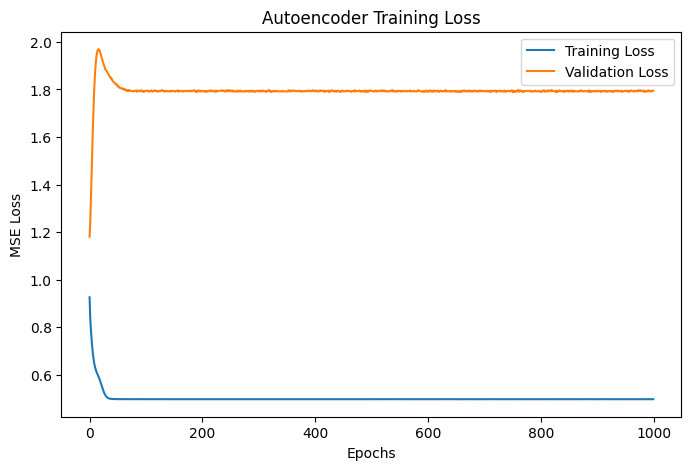

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Extract the feature columns
X = dims_df.values

# Standardize the data for better training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Build Autoencoder
input_dim = X_scaled.shape[1]  # Number of features (9 in your case)
encoding_dim = 1  # Bottleneck dimension

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
bottleneck = Dense(encoding_dim, activation='elu', name='bottleneck')(input_layer)

# Decoder
output_layer = Dense(input_dim, activation='elu')(bottleneck)

# Build Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Encoder Model (to extract the bottleneck later)
encoder = Model(inputs=input_layer, outputs=bottleneck)

# Compile Autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Step 3: Train Autoencoder
history = autoencoder.fit(X_scaled, X_scaled, epochs=1000, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

# Step 4: Extract 1D Bottleneck Representation
bottleneck_output = encoder.predict(X_scaled)

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Optional: Save Bottleneck to DataFrame
bottleneck_df = pd.DataFrame(bottleneck_output, columns=['Bottleneck_1D'])


In [16]:
bottleneck_df

,Bottleneck_1D
0,1.338387
1,0.889213
2,1.531270
3,1.192324
4,1.517324
...,...
2499,0.157768
2500,0.029019
2501,0.187910
2502,0.152300


In [45]:
path_data = f"{CONFIG['PATH_data']}/"
iterations = [f for f in os.listdir(path_data) if f.startswith('iteration')]
for iteration in iterations[1:2]:
    path_iteration = f"{path_data}/{iteration}/"
    ids = pd.read_pickle(f"{path_iteration}/ids.pkl")
    dims_dfs = []
    for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        temp_ids = ids[ids[f"cluster_{iteration.split('_')[1]}"] == pop]
        path_pop = f"{path_iteration}/pop_{pop}/"
        dims = [f for f in os.listdir(path_pop) if f.startswith('PCs')]
        
        nr_PCs = 3
        PCs_labels = []
        for i in range(nr_PCs):
            PCs_labels.append(f"PC{i+1}")

        dims_df = pd.DataFrame()
        for dim  in dims:
            path_dim = f"{path_pop}/{dim}"
            dim = dim.split('PCs_')[1].split('.pkl')[0]
            
            PCs = pd.read_pickle(path_dim)
            for label in PCs_labels:
                PCs.rename(columns={f"{label}": f"pop_{pop}_{label}_dim_{dim}"}, inplace=True)
                dims_df[f"pop_{pop}_{label}_dim_{dim}"] = list(PCs[f"pop_{pop}_{label}_dim_{dim}"])
        dims_df.index = temp_ids.index
        dims_dfs.append(dims_df)
            
    

In [47]:

# Concatenate DataFrames, filling missing columns with NaN
result = pd.concat(dims_dfs, ignore_index=False, sort=True)
result = result.fillna(0)
result

,pop_0_0_PC1_dim_dim_1,pop_0_0_PC1_dim_dim_2,pop_0_0_PC1_dim_dim_3,pop_0_0_PC2_dim_dim_1,pop_0_0_PC2_dim_dim_2,pop_0_0_PC2_dim_dim_3,pop_0_0_PC3_dim_dim_1,pop_0_0_PC3_dim_dim_2,pop_0_0_PC3_dim_dim_3,pop_0_1_PC1_dim_dim_1,...,pop_0_3_PC3_dim_dim_3,pop_0_4_PC1_dim_dim_1,pop_0_4_PC1_dim_dim_2,pop_0_4_PC1_dim_dim_3,pop_0_4_PC2_dim_dim_1,pop_0_4_PC2_dim_dim_2,pop_0_4_PC2_dim_dim_3,pop_0_4_PC3_dim_dim_1,pop_0_4_PC3_dim_dim_2,pop_0_4_PC3_dim_dim_3
0,0.933013,-4.068720,10.336285,-3.492381,9.887428,-2.532068,9.639750,2.783962,7.823999,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.188379,-4.959371,16.235042,-2.123308,21.497266,3.080950,20.465567,0.438365,-1.994241,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.393187,-6.371439,-3.397163,-6.866763,-3.048944,6.415818,1.044204,2.575572,-2.637278,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.743959,-6.591337,7.333168,-6.852792,8.612897,-1.655533,8.877612,-0.498862,-0.818207,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.883044,-5.209089,2.450627,-4.378275,1.098689,2.820204,-2.990109,-2.853764,-3.851209,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.935759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.250069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.184803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.753146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
